In [1]:
REPORT_PATH = '../out/reports/credit.pkl'
FIGS_PATH = '../out/images'
WEIGHTED_EPSILONS = [2.5, 5]
BEST_FIRST_EPSILON = 10e+5  # A hack to emulate greedy best-first search: have a very high epsilon.
FOCUS_BINS = 50
FIGWIDTH = 8.5
FIGHEIGHT = 6.5
SAVE_PLOTS = False
MARKERS = ['D', '*', 'o', 's', 'P']

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('..')

In [4]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from collections import defaultdict

import pickle

import plot_params

### Utilities

In [5]:
def load_results(datafile):
    with open(datafile, 'rb') as f:
        results = pickle.load(f)
        return results
    
def group_by_key(data, key):
    obj = defaultdict(list)
    for d in data:
        value = d[key]
        obj[value].append(d)        
    return obj

def save_fig(fig, name_template, *args, **kwargs):
    fig.savefig(os.path.join(FIGS_PATH, name_template.format(*args, **kwargs)))

In [6]:
def get_runtime_improvement(ast_results, ucs_results):
    assert ast_results['index'].equals(ucs_results['index'])
    assert ast_results['found'].equals(ucs_results['found'])
    
    # Get the measurements
    ucs_expansions = ucs_results['nodes_expanded']
    ast_expansions = ast_results['nodes_expanded']
    ucs_runtimes = ucs_results['runtime']
    ast_runtimes = ast_results['runtime']
    
    # Obtain indexes that would sort the UCS expansions array.
    idxs = np.argsort(ucs_expansions.values)
    
    # Use indexes to sort UCS and A* expansion counts and runtimes.
    ucs_expansions_sorted = ucs_expansions.values[idxs]
    ast_expansions_sorted = ast_expansions.values[idxs]
    ucs_runtimes_sorted = ucs_runtimes.values[idxs]
    ast_runtimes_sorted = ast_runtimes.values[idxs]
    
    improvement = (ucs_expansions_sorted / ast_expansions_sorted)
    return improvement, ast_runtimes_sorted, ucs_runtimes_sorted, \
           ast_expansions_sorted, ucs_expansions_sorted

In [7]:
def get_path_cost_increase(ast_results, ucs_results):
    assert ast_results['index'].equals(ucs_results['index'])
    assert ast_results['found'].equals(ucs_results['found'])
    
    print(ucs_results.columns)
    
    # Get the expansion arrays.
    ucs_path_cost = ucs_results['path_cost']
    ast_path_cost = ast_results['path_cost']
    
    # Obtain indexes that would sort the ucs expansions array.
    idxs = np.argsort(ucs_path_cost.values)
    
    # Use indexes to sort ucs and A* expansions arrays and compute improvement. 
    ucs_path_cost_sorted = ucs_path_cost.values[idxs]
    ast_path_cost_sorted = ast_path_cost.values[idxs]
    
    increase = (ast_path_cost_sorted / ucs_path_cost_sorted)
    return increase, ast_path_cost_sorted, ucs_path_cost_sorted

### Load data

In [8]:
# Load results from running adversarial search on credit dataset.
results = load_results(REPORT_PATH)

### Plot results over different bins

In [9]:
results_by_bins = group_by_key(results, 'bins')
attack_perf_df = pd.DataFrame(columns=['bins', 'index', 'expansions', 'improvement', 'eps'])
clf_perf_df = pd.DataFrame(columns=['bins', 'accuracy', 'robustness'])
costs_df = pd.DataFrame(columns=['bins', 'index', 'eps', 'robustness', 'pathcost', 'pathcostincrease'])

models = []
ucs_results_by_bins = group_by_key(group_by_key(results, 'epsilon').get(0), 'bins')
for bins, items in results_by_bins.items():
    clf_perf_df = clf_perf_df.append({
            'bins': bins,
            'accuracy': items[0]['clf_test_score'],
            'robustness': items[0]['avg_robustness']
        }, ignore_index=True)
    models.append(items[0]['classifier'])
    
    for item in items:
        ast_results = item['search_results']
        ucs_results = ucs_results_by_bins[bins][0]['search_results']
        
        ast_results = ast_results.sort_values('index')
        ucs_results = ucs_results.sort_values('index')
        assert ast_results['index'].equals(ucs_results['index'])
        
        item_data = zip(
            ast_results['index'],
            ast_results['runtime'],
            ast_results['nodes_expanded'],
            ucs_results['nodes_expanded'])
        
        # Record attack runtime performance vs. UCS.
        for index, ast_runtime, ast_expansions, ucs_expansions in item_data:           
            attack_perf_df = attack_perf_df.append(
                {
                    'bins': bins,
                    'index': index,
                    'eps': item['epsilon'],
                    'runtime': ast_runtime,
                    'expansions': ast_expansions,
                    'improvement': ucs_expansions / ast_expansions,
                },
                ignore_index=True
            )
        
        # Record attack cost performance vs. UCS.
        for index, ast_path_cost, ucs_path_cost in zip(
                ast_results['index'], ast_results['path_cost'], ucs_results['path_cost']):
            
            # Re-compute adv.robustness in R^m for each point.
            example = list(ast_results.query('index==%d' % index)['x_features'])[0]
            robustness = np.abs(item['classifier'].decision_function([example])[0]) \
                / np.linalg.norm(item['classifier'].coef_[0], ord=item['q_norm'])
            
            ucs_results.sort_values
            costs_df = costs_df.append(
                {
                    'bins': bins,
                    'index': index,
                    'eps': item['epsilon'],
                    'robustness': robustness,
                    'pathcost': ucs_path_cost,
                    'pathcostincrease': ast_path_cost / ucs_path_cost
                },
                ignore_index=True
            )

In [10]:
coefs = np.array([model.coef_[0] for model in models])

In [11]:
coefs_norm = []
for coef_vec in coefs:
    coef_vec_norm = np.array(coef_vec)
    coef_vec_norm += np.abs(np.min(coef_vec_norm))
    coef_vec_norm /= np.sum(np.abs(coef_vec_norm))
    coefs_norm.append(coef_vec_norm)
    
coefs_norm = np.array(coefs_norm)

In [12]:
sharpness = np.array([np.ediff1d(coef).mean() for coef in coefs_norm])

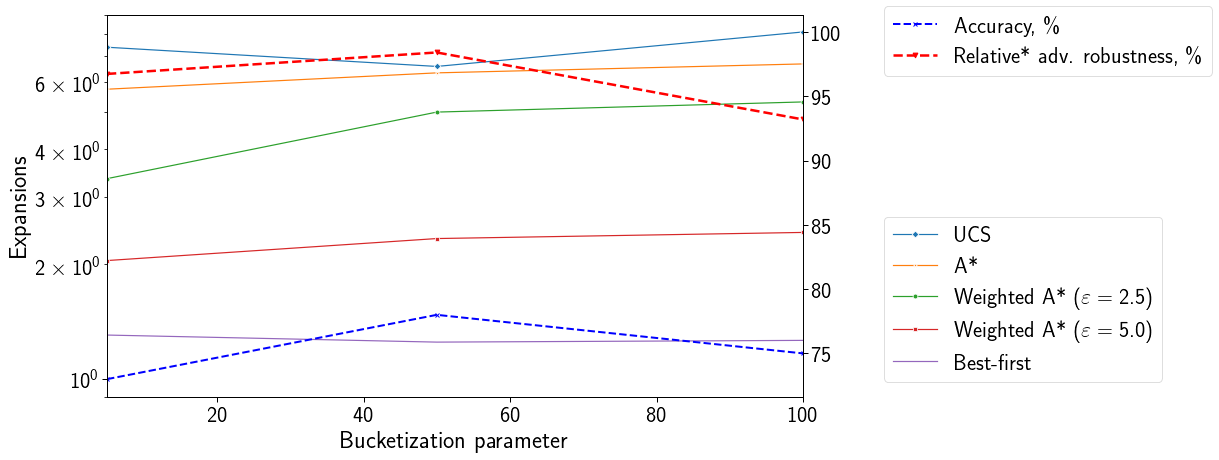

In [13]:
fig, ax = plt.subplots()

sns.lineplot(data=attack_perf_df.query('eps == 0'),
             x='bins', y='expansions', ax=ax, label='UCS', ci=None,
             marker=MARKERS[0])

sns.lineplot(data=attack_perf_df.query('eps == 1'),
             x='bins', y='expansions', ax=ax, label='A*', ci=None, 
             marker=MARKERS[1])

for i, eps in enumerate(WEIGHTED_EPSILONS):
    sns.lineplot(data=attack_perf_df.query('{0} - 0.1 < eps < {0} + 0.1'.format(eps)),
                 x='bins', y='expansions', ax=ax,
                 label='Weighted A* ($\\varepsilon = %1.1f$)' % eps,
                 ci=None, marker=MARKERS[i + 2])

if BEST_FIRST_EPSILON is not None:
    sns.lineplot(data=attack_perf_df.query('eps == %d' % BEST_FIRST_EPSILON),
                 x='bins', y='expansions', ax=ax, label='Best-first',
                 ci=None)

ax.set_ylabel('Expansions')
ax.set_xlabel('Bucketization parameter')
ax.set_xlim(5, 100)
ax.set_yscale('log')
legend_artist = ax.legend(bbox_to_anchor=(1.1, 0.5))

ax2 = ax.twinx()
ax2.plot(clf_perf_df.bins, clf_perf_df.accuracy,
         label='Accuracy, \%',
         linestyle='--', color='blue', marker='x', linewidth=2)
ax2.plot(clf_perf_df.bins, clf_perf_df.robustness / clf_perf_df.robustness.max() * 100,
         label='Relative* adv. robustness, \%',
         linestyle='--', color='red', marker='v', linewidth=2.5)
# ax2.set_yscale('log')
legend_artist2 = ax2.legend(loc=2, bbox_to_anchor=(1.1, 1.05))

fig.set_figwidth(FIGWIDTH * 2)
fig.set_figheight(FIGHEIGHT)
fig.set_tight_layout('tight')

if SAVE_PLOTS:
    save_fig(fig, 'credit_different_bins_perf.pdf')

### Plot results for one bin

In [14]:
# Group the results by the required key.
results_by_key = group_by_key(results, 'epsilon')

RUNTIME_FACTOR = 1

expansion_improvements_by_eps = {}
ast_expansions_by_eps = {}
ast_runtimes_by_eps = {}
ucs_expansions = None
ucs_runtimes = None
for epsilon, items in results_by_key.items():
    for item in items:
        if item['bins'] != FOCUS_BINS:
            continue
        
        ast_results = item['search_results']
        ucs_results = ucs_results_by_bins.get(FOCUS_BINS)[0]['search_results']
        t = get_runtime_improvement(ast_results, ucs_results)
        (improvements, ast_runtimes_sorted, ucs_runtimes_sorted,\
         ast_expansions_sorted, ucs_expansions_sorted) = t
        ucs_expansions = ucs_expansions_sorted
        ucs_runtimes = ucs_runtimes_sorted * RUNTIME_FACTOR
        
        expansion_improvements_by_eps[epsilon] = np.array(improvements)
        ast_expansions_by_eps[epsilon] = np.array(ast_expansions_sorted)
        ast_runtimes_by_eps[epsilon] = np.array(ast_runtimes_sorted) * RUNTIME_FACTOR

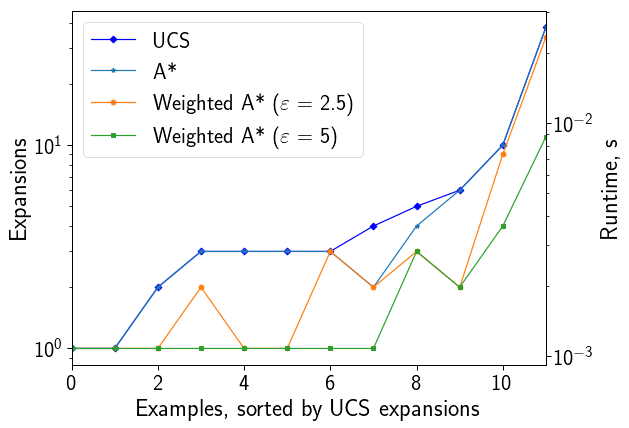

In [15]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(ucs_expansions, color='blue', label='UCS', marker=MARKERS[0])
ax2.plot(ucs_runtimes, color='blue', label='UCS',
         linestyle='None')

ax.plot(ast_expansions_by_eps[1], label='A*', marker=MARKERS[1])
ax2.plot(ast_runtimes_by_eps[1], label='A*',
         linestyle='None')

for i, eps in enumerate(WEIGHTED_EPSILONS):
    expansions = ast_expansions_by_eps[eps]
    runtimes = ast_runtimes_by_eps[eps]
    ax.plot(expansions, label='Weighted A* ($\\varepsilon$ = {})'.format(eps), marker=MARKERS[i + 2])
    ax2.plot(runtimes, label='Weighted A* ($\\varepsilon$ = {})'.format(eps),
             linestyle='None')
    
ax.set_xlabel('Examples, sorted by UCS expansions')
ax.set_ylabel('Expansions')
ax.set_xlim(0, len(ucs_expansions) - 1)
ax.set_yscale('log')
ax.legend(loc='best')

ax2.set_ylabel('Runtime, s')
ax2.set_yscale('log')

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)

plt.show()

if SAVE_PLOTS:
    save_fig(fig, 'credit_performance_bin_{}.pdf', FOCUS_BINS)

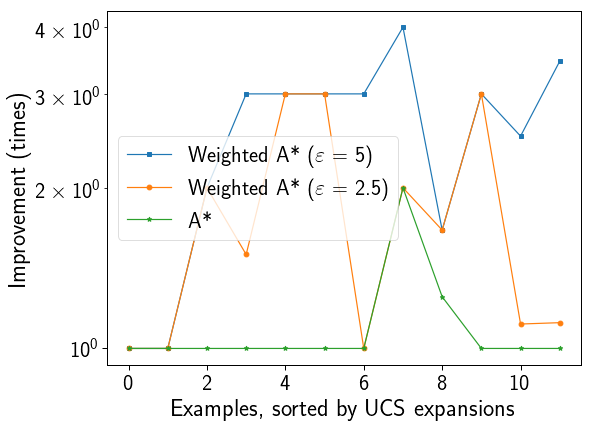

In [16]:
fig, ax = plt.subplots()

for i, eps in reversed(list(enumerate(WEIGHTED_EPSILONS))):
    improv = expansion_improvements_by_eps[eps]
    ax.plot(improv, label='Weighted A* ($\\varepsilon$ = {})'.format(eps),
            marker=MARKERS[i + 2])
    
ax.plot(expansion_improvements_by_eps[1], label='A*', marker=MARKERS[1])
   
ax.set_xlabel('Examples, sorted by UCS expansions')
ax.set_ylabel('Improvement (times)')
ax.set_yscale('log')
ax.legend(loc='best')

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)

if SAVE_PLOTS:
    save_fig(fig, 'credit_improvement_bin_{}.pdf', FOCUS_BINS)

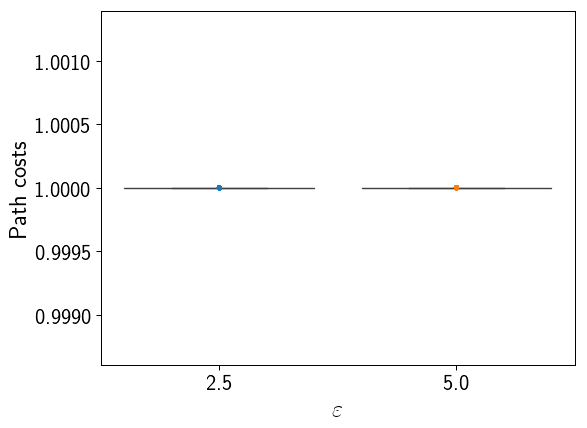

In [17]:
fig, ax = plt.subplots()

data_df = costs_df.query('eps in %s' % WEIGHTED_EPSILONS)
sns.boxplot(data=data_df, x='eps', y='pathcostincrease', ax=ax, showfliers=False)
sns.stripplot(data=data_df, x='eps', y='pathcostincrease', ax=ax, jitter=False)

ax.set_ylabel('Path costs')
ax.set_xlabel('$\\varepsilon$')

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)

if SAVE_PLOTS:
    save_fig(fig, 'credit_path_costs.pdf')

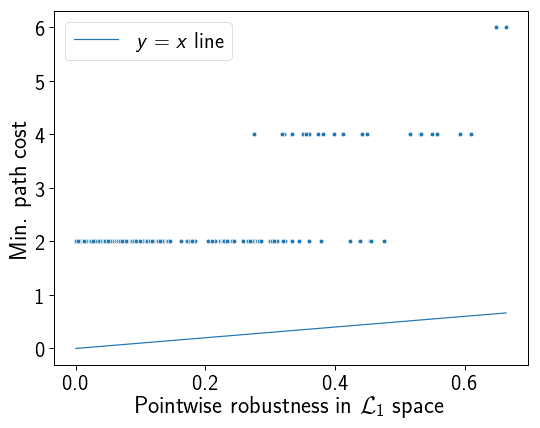

In [18]:
fig, ax = plt.subplots()
ast_costs_df = costs_df.query('eps==1')
sns.scatterplot(data=ast_costs_df,
            x='robustness', y='pathcost', ax=ax)

xs = [ast_costs_df.robustness.min(), ast_costs_df.robustness.max()]
plt.plot(xs, xs, label='$y = x$ line')

ax.legend()
ax.set_xlabel('Pointwise robustness in $\mathcal{L}_%d$ space' % item['p_norm'])
ax.set_ylabel('Min. path cost')

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)

if SAVE_PLOTS:
    save_fig(fig, 'credit_mac_comparison.pdf')